# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Alina Kitieva'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

We will need the following libraries, but of course you can add the libraries you prefer.

In [3]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [4]:
from urllib.parse import urljoin, urlparse
from typing import List
from functools import wraps


def validate_url(func):
    @wraps(func)
    def wrapper(url: str, *args, **kwargs):
        result = urlparse(url)
        if not all([result.scheme, result.netloc]):
            logger.error(f"Invalid URL: {url}. Error: Invalid URL format")
            raise ValueError("Invalid URL format")
        return func(url, *args, **kwargs)
    return wrapper


class WebScraper:
    @staticmethod
    def fetch_page(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            logger.error(f"Error fetching page: {str(e)}")
            raise

    @staticmethod
    def parse_links(html: str, base_url: str) -> List[str]:
        soup = BeautifulSoup(html, 'html.parser')
        links = []
        for anchor in soup.find_all('a'):
            href = anchor.get('href')
            if href:
                absolute_url = urljoin(base_url, href)
                if absolute_url.startswith(('http://', 'https://')):
                    links.append(absolute_url)
        return links

In [5]:
@validate_url
def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """

    scraper = WebScraper()
    html = scraper.fetch_page(url)
    return scraper.parse_links(html, url)

In [6]:
get_all_links('http://en.wikipedia.com')[:10]

['http://en.wikipedia.com#bodyContent',
 'http://en.wikipedia.com/wiki/Main_Page',
 'http://en.wikipedia.com/wiki/Wikipedia:Contents',
 'http://en.wikipedia.com/wiki/Portal:Current_events',
 'http://en.wikipedia.com/wiki/Special:Random',
 'http://en.wikipedia.com/wiki/Wikipedia:About',
 'http://en.wikipedia.org/wiki/Wikipedia:Contact_us',
 'http://en.wikipedia.com/wiki/Help:Contents',
 'http://en.wikipedia.com/wiki/Help:Introduction',
 'http://en.wikipedia.com/wiki/Wikipedia:Community_portal']

In [7]:
import unittest
from unittest.mock import patch, MagicMock


class TestGetAllLinks(unittest.TestCase):
    def setUp(self):
        self.valid_url = "https://example.com"
        self.invalid_url = "not_a_url"
        self.sample_html = """
        <html>
            <body>
                <a href="https://example.com/page1">Link 1</a>
                <a href="/relative/path">Link 2</a>
                <a href="https://example.com/page2">Link 3</a>
                <a>Invalid Link</a>
            </body>
        </html>
        """

    def test_invalid_url(self):
        with self.assertRaises(ValueError):
            get_all_links(self.invalid_url)

    @patch('requests.get')
    def test_successful_fetch(self, mock_get):
        mock_response = MagicMock()
        mock_response.text = self.sample_html
        mock_response.status_code = 200
        mock_get.return_value = mock_response

        links = get_all_links(self.valid_url)
        self.assertEqual(len(links), 3)
        self.assertIn("https://example.com/page1", links)
        self.assertIn("https://example.com/relative/path", links)
        self.assertIn("https://example.com/page2", links)

    @patch('requests.get')
    def test_request_exception(self, mock_get):
        mock_get.side_effect = requests.RequestException("Mocked exception")
        with self.assertRaises(requests.RequestException):
            get_all_links(self.valid_url)

    def test_relative_url_conversion(self):
        scraper = WebScraper()
        links = scraper.parse_links(self.sample_html, self.valid_url)
        self.assertEqual(len(links), 3)
        self.assertIn("https://example.com/relative/path", links)

    @patch('requests.get')
    def test_empty_page(self, mock_get):
        mock_response = MagicMock()
        mock_response.text = "<html><body>No links here</body></html>"
        mock_response.status_code = 200
        mock_get.return_value = mock_response

        links = get_all_links(self.valid_url)
        self.assertEqual(len(links), 0)


suite_depth = unittest.TestLoader().loadTestsFromTestCase(TestGetAllLinks)
unittest.TextTestRunner(verbosity=2).run(suite_depth)


test_empty_page (__main__.TestGetAllLinks.test_empty_page) ... ok
test_invalid_url (__main__.TestGetAllLinks.test_invalid_url) ... ERROR:__main__:Invalid URL: not_a_url. Error: Invalid URL format
ok
test_relative_url_conversion (__main__.TestGetAllLinks.test_relative_url_conversion) ... ok
test_request_exception (__main__.TestGetAllLinks.test_request_exception) ... ERROR:__main__:Error fetching page: Mocked exception
ok
test_successful_fetch (__main__.TestGetAllLinks.test_successful_fetch) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [8]:
from typing import Generator

@validate_url
def get_neighbor_pages(url: str) -> Generator[str, None, None]:
    """
    Go through the links in the webpage at the given URL
    and yield the html content of each of them

    :param url: A string that is the URL of the webpage
    """

    scraper = WebScraper()
    
    try:
        initial_html = scraper.fetch_page(url)
        links = scraper.parse_links(initial_html, url)
        
        for link in links:
            try:
                html_content = scraper.fetch_page(link)
                yield html_content
            except requests.RequestException as e:
                logger.warning(f"Skipping {link} due to error: {str(e)}")
                continue
                
    except requests.RequestException as e:
        logger.error(f"Error processing initial URL {url}: {str(e)}")
        raise

In [9]:
import unittest


class TestGetNeighborPages(unittest.TestCase):
    def setUp(self):
        self.valid_url = "https://example.com"
        self.invalid_url = "not_a_url"
        self.sample_html = """
        <html>
            <body>
                <a href="https://example.com/page1">Link 1</a>
                <a href="https://example.com/page2">Link 2</a>
            </body>
        </html>
        """
        self.page1_content = "<html>Page 1</html>"
        self.page2_content = "<html>Page 2</html>"

    @patch('requests.get')
    def test_valid_url_with_links(self, mock_get):
        mock_responses = [
            MagicMock(text=self.sample_html),
            MagicMock(text=self.page1_content),
            MagicMock(text=self.page2_content)
        ]
        mock_get.side_effect = mock_responses

        generator = get_neighbor_pages(self.valid_url)
        
        pages = list(generator)
        
        self.assertEqual(len(pages), 2)
        self.assertEqual(pages[0], self.page1_content)
        self.assertEqual(pages[1], self.page2_content)

    def test_invalid_url(self):
        with self.assertRaises(ValueError):
            list(get_neighbor_pages(self.invalid_url))

    @patch('requests.get')
    def test_network_error(self, mock_get):
        mock_get.side_effect = requests.RequestException("Network error")
        
        with self.assertRaises(requests.RequestException):
            list(get_neighbor_pages(self.valid_url))

    @patch('requests.get')
    def test_partial_failure(self, mock_get):
        mock_get.side_effect = [
            MagicMock(text=self.sample_html),
            requests.RequestException("Failed to fetch page 1"),
            MagicMock(text=self.page2_content)
        ]

        generator = get_neighbor_pages(self.valid_url)
        pages = list(generator)
        
        self.assertEqual(len(pages), 1)
        self.assertEqual(pages[0], self.page2_content)

    @patch('requests.get')
    def test_empty_page(self, mock_get):
        mock_get.return_value = MagicMock(text="<html><body>No links here</body></html>")
        
        generator = get_neighbor_pages(self.valid_url)
        pages = list(generator)
        
        self.assertEqual(len(pages), 0)


suite_depth = unittest.TestLoader().loadTestsFromTestCase(TestGetNeighborPages)
unittest.TextTestRunner(verbosity=2).run(suite_depth)

test_empty_page (__main__.TestGetNeighborPages.test_empty_page) ... ok
test_invalid_url (__main__.TestGetNeighborPages.test_invalid_url) ... ERROR:__main__:Invalid URL: not_a_url. Error: Invalid URL format
ok
test_network_error (__main__.TestGetNeighborPages.test_network_error) ... ERROR:__main__:Error fetching page: Network error
ERROR:__main__:Error processing initial URL https://example.com: Network error
ok
test_partial_failure (__main__.TestGetNeighborPages.test_partial_failure) ... ERROR:__main__:Error fetching page: Failed to fetch page 1
ok
test_valid_url_with_links (__main__.TestGetNeighborPages.test_valid_url_with_links) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.069s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

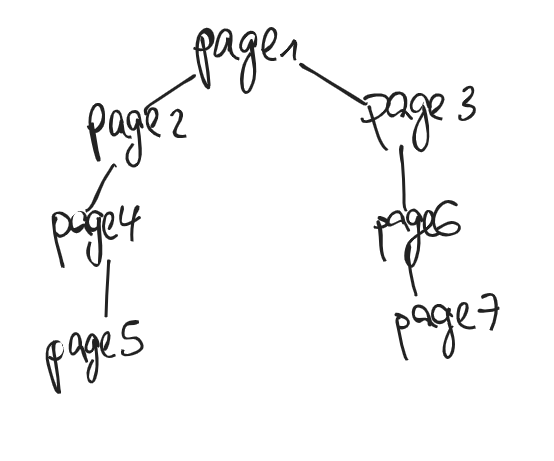

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [10]:
def track_visited_urls(func):
    visited_urls = set()
    
    @wraps(func)
    def wrapper(url: str, depth: int, *args, **kwargs):
        def is_visited(url: str) -> bool:
            return url in visited_urls

        def mark_visited(url: str) -> None:
            visited_urls.add(url)
        
        return func(url, depth, is_visited, mark_visited, *args, **kwargs)
    return wrapper



@track_visited_urls
@validate_url
def get_pages_depth(url: str, depth: int, is_visited=None, mark_visited=None) -> Generator[str, None, None]:
    """
    Traverse the web pages starting from the given URL up to the specified depth
    and yield the HTML content of each page.

    Args:
        url (str): The starting URL.
        depth (int): The depth to traverse.
        is_visited (callable): Function to check if a URL has been visited.
        mark_visited (callable): Function to mark a URL as visited.

    Yields:
        str: HTML content of each visited page.
    """
    if depth < 0:
        logger.error("Depth cannot be negative")
        raise ValueError("Depth cannot be negative")

    scraper = WebScraper()
    queue = [(url, 0)]

    while queue:
        current_url, current_depth = queue.pop(0)
        
        if is_visited(current_url):
            continue
        mark_visited(current_url)

        try:
            html_content = scraper.fetch_page(current_url)
            yield html_content

            if current_depth < depth:
                try:
                    links = scraper.parse_links(html_content, current_url)
                    for link in links:
                        if not is_visited(link):
                            queue.append((link, current_depth + 1))
                except Exception as e:
                    logger.warning(f"Error parsing links from {current_url}: {str(e)}")
                    continue

        except requests.RequestException as e:
            logger.warning(f"Error processing {current_url}: {str(e)}")
            continue


In [11]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [12]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clien

In [13]:
import unittest

class TestGetPagesDepth(unittest.TestCase):
    def setUp(self):
        self.mock_html_1 = """
        <html><body>
            <a href="http://example.com/page2">Link to Page 2</a>
            <a href="http://example.com/page3">Link to Page 3</a>
        </body></html>
        """
        self.mock_html_2 = """
        <html><body>
            <a href="http://example.com/page4">Link to Page 4</a>
        </body></html>
        """
        self.mock_html_3 = """
        <html><body>
            <a href="http://example.com/page1">Link back to Page 1</a>
        </body></html>
        """
        self.mock_html_cyclic_page1 = """
            <html><body>
                <a href="http://newexample.com/page2">Link to Page 2</a>
            </body></html>
        """
        self.mock_html_cyclic_page2 = """
            <html><body>
                <a href="http://newexample.com/page1">Link back to Page 1</a>
            </body></html>
        """

    @patch('requests.get')
    def test_basic_depth_traversal(self, mock_get):
        mock_responses = {
            'http://example.com/page1': self.mock_html_1,
            'http://example.com/page2': self.mock_html_2,
            'http://example.com/page3': self.mock_html_3,
        }
        
        def mock_get_response(url, *args, **kwargs):
            if url in mock_responses:
                mock_response = MagicMock()
                mock_response.text = mock_responses[url]
                mock_response.status_code = 200
                mock_response.raise_for_status = MagicMock()
                return mock_response
            else:
                raise requests.RequestException(f"URL not found: {url}")
                
        mock_get.side_effect = mock_get_response

        pages = list(get_pages_depth('http://example.com/page1', 1))
        self.assertEqual(len(pages), 3)
        self.assertIn(self.mock_html_1, pages)
        self.assertIn(self.mock_html_2, pages)
        self.assertIn(self.mock_html_3, pages)

    def test_negative_depth(self):
        with self.assertRaises(ValueError):
            list(get_pages_depth('http://example.com', -1))

    def test_invalid_url(self):
        with self.assertRaises(ValueError):
            list(get_pages_depth('invalid_url', 1))

    @patch('requests.get')
    def test_connection_error(self, mock_get):
        mock_get.side_effect = requests.RequestException("Connection error")
        pages = list(get_pages_depth('http://example.com', 1))
        self.assertEqual(len(pages), 0)

    @patch('requests.get')
    def test_cyclic_links(self, mock_get):
        mock_responses = {
            'http://newexample.com/page1': self.mock_html_cyclic_page1,
            'http://newexample.com/page2': self.mock_html_cyclic_page2,
        }
        
        def mock_get_response(url, *args, **kwargs):
            if url in mock_responses:
                mock_response = MagicMock()
                mock_response.text = mock_responses[url]
                mock_response.status_code = 200
                mock_response.raise_for_status = MagicMock()
                return mock_response
            else:
                raise requests.RequestException(f"URL not found: {url}")
                
        mock_get.side_effect = mock_get_response

        pages = list(get_pages_depth('http://newexample.com/page1', 2))
        self.assertEqual(len(pages), 2)
        self.assertIn(self.mock_html_cyclic_page1, pages)
        self.assertIn(self.mock_html_cyclic_page2, pages)


suite = unittest.TestLoader().loadTestsFromTestCase(TestGetPagesDepth)
unittest.TextTestRunner(verbosity=2).run(suite)


test_basic_depth_traversal (__main__.TestGetPagesDepth.test_basic_depth_traversal) ... ok
test_connection_error (__main__.TestGetPagesDepth.test_connection_error) ... ERROR:__main__:Error fetching page: Connection error
ok
test_cyclic_links (__main__.TestGetPagesDepth.test_cyclic_links) ... ok
test_invalid_url (__main__.TestGetPagesDepth.test_invalid_url) ... ERROR:__main__:Invalid URL: invalid_url. Error: Invalid URL format
ok
test_negative_depth (__main__.TestGetPagesDepth.test_negative_depth) ... ERROR:__main__:Depth cannot be negative
ok

----------------------------------------------------------------------
Ran 5 tests in 0.024s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [14]:
from dataclasses import dataclass, field
from typing import List, Optional
import re
import random


@dataclass
class ComputerScientist:
    name: str
    birthdate: Optional[str] = None
    major_achievements: List[str] = field(default_factory=list)
    alma_mater: List[str] = field(default_factory=list)
    fields_of_expertise: List[str] = field(default_factory=list)
    wikipedia_url: Optional[str] = None

    def add_achievement(self, achievement: str):
        if achievement and achievement not in self.major_achievements:
            self.major_achievements.append(achievement)
            logger.debug(f"Added achievement '{achievement}' to {self.name}")

    def add_alma_mater(self, institution: str):
        if institution and institution not in self.alma_mater:
            self.alma_mater.append(institution)
            logger.debug(f"Added alma mater '{institution}' to {self.name}")

    def add_field_of_expertise(self, field: str):
        if field and field not in self.fields_of_expertise:
            self.fields_of_expertise.append(field)
            logger.debug(f"Added field of expertise '{field}' to {self.name}")

    def __str__(self):
        return f"{self.name} ({self.birthdate})"

    def __repr__(self):
        return (f"ComputerScientist(name={self.name!r}, birthdate={self.birthdate!r}, "
                f"major_achievements={self.major_achievements!r}, alma_mater={self.alma_mater!r}, "
                f"fields_of_expertise={self.fields_of_expertise!r}, wikipedia_url={self.wikipedia_url!r})")


def fetch_computer_scientists_list(url: str) -> List[dict]:
    """
    Fetches the list of computer scientists from the given Wikipedia URL.
    Returns a list of dictionaries with 'name' and 'link'.
    """
    logger.info(f"Fetching computer scientists list from {url}")
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    scientists = []
    sections = soup.find_all('div', class_='mw-heading mw-heading2')
    for section in sections:
        ul = section.find_next_sibling('ul')
        if not ul:
            continue
        for li in ul.find_all('li', recursive=False):
            a_tag = li.find('a')
            if a_tag and 'href' in a_tag.attrs:
                name = a_tag.get_text().strip()
                link = 'https://en.wikipedia.org' + a_tag['href']
                scientists.append({'name': name, 'link': link})
    logger.info(f"Found {len(scientists)} computer scientists in the list")
    return scientists


def fetch_individual_scientist_info(scientist: dict) -> Optional[ComputerScientist]:
    """
    Fetches detailed information about a single computer scientist from their Wikipedia page.
    Returns a ComputerScientist object or None if fetching fails.
    """
    name = scientist['name']
    link = scientist['link']
    logger.debug(f"Fetching information for {name} from {link}")
    try:
        response = requests.get(link)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        cs = ComputerScientist(name=name, wikipedia_url=link)

        infobox = soup.find('table', class_='infobox')
        if infobox:
            born_row = infobox.find('th', string=re.compile('Born'))
            if born_row:
                birthdate_td = born_row.find_next_sibling('td')
                if birthdate_td:
                    birthdate = birthdate_td.get_text(separator=' ', strip=True)
                    cs.birthdate = birthdate

            alma_mater_row = infobox.find('th', string=re.compile('Alma mater'))
            if alma_mater_row:
                alma_mater_td = alma_mater_row.find_next_sibling('td')
                if alma_mater_td:
                    institutions = [a.get_text(strip=True) for a in alma_mater_td.find_all('a')]
                    cs.alma_mater.extend(institutions)

        paragraphs = soup.find_all('p')
        if paragraphs:
            intro = paragraphs[0].get_text(separator=' ', strip=True)
            fields = re.split(',| and ', intro)
            fields = [field.strip() for field in fields if field.strip()]
            cs.fields_of_expertise.extend(fields[:5])  # Limit to first 5 for brevity

        known_for = []
        for header in soup.find_all(['h2', 'h3']):
            if 'known for' in header.get_text().lower():
                ul = header.find_next_sibling('ul')
                if ul:
                    known_for = [li.get_text(strip=True) for li in ul.find_all('li')]
                    cs.major_achievements.extend(known_for)
                break

        logger.debug(f"Extracted data for {name}: {cs}")
        return cs

    except requests.RequestException as e:
        logger.error(f"Request failed for {name}: {e}")
    except Exception as e:
        logger.error(f"Failed to parse information for {name}: {e}")
    return None


def get_random_computer_scientists(count: int = 100) -> List[ComputerScientist]:
    """
    Fetches information about a specified number of random computer scientists.
    Returns a list of ComputerScientist objects.
    """
    list_url = 'https://en.wikipedia.org/wiki/List_of_computer_scientists'
    scientists_list = fetch_computer_scientists_list(list_url)
    if len(scientists_list) < count:
        logger.warning(f"Requested {count} scientists, but only found {len(scientists_list)}")
        count = len(scientists_list)
    selected_scientists = random.sample(scientists_list, count)
    computer_scientists = []

    for scientist in selected_scientists:
        cs = fetch_individual_scientist_info(scientist)
        if cs:
            computer_scientists.append(cs)
        else:
            logger.warning(f"Skipping {scientist['name']} due to fetch/parsing issues")

    logger.info(f"Successfully fetched {len(computer_scientists)} computer scientists")
    return computer_scientists

computer_scientists = get_random_computer_scientists(100)

computer_scientists[:5]


INFO:__main__:Fetching computer scientists list from https://en.wikipedia.org/wiki/List_of_computer_scientists
INFO:__main__:Found 698 computer scientists in the list
INFO:__main__:Successfully fetched 100 computer scientists


[ComputerScientist(name='Jeffrey D. Ullman', birthdate='( 1942-11-22 ) November 22, 1942 (age\xa082)', major_achievements=[], alma_mater=[], fields_of_expertise=[], wikipedia_url='https://en.wikipedia.org/wiki/Jeffrey_D._Ullman'),
 ComputerScientist(name='Reinder van de Riet', birthdate='( 1939-04-22 ) 22 April 1939 Groningen , Netherlands', major_achievements=[], alma_mater=[], fields_of_expertise=['Reinder Pieter (Reind) van de Riet (22 April 1939', 'Groningen – 18 December 2008', 'Baarn ) [ 1 ] was a Dutch computer scientist', 'Emeritus Professor Information Systems at the Vrije Universiteit Amsterdam', 'known for the development of COLOR-X'], wikipedia_url='https://en.wikipedia.org/wiki/Reinder_van_de_Riet'),
 ComputerScientist(name='Simon Colton', birthdate='1973 Nottingham', major_achievements=[], alma_mater=[], fields_of_expertise=[], wikipedia_url='https://en.wikipedia.org/wiki/Simon_Colton'),
 ComputerScientist(name='Jeff Bonwick', birthdate=None, major_achievements=[], alma_m

In [15]:
import unittest


class TestComputerScientist(unittest.TestCase):

    def setUp(self):
        self.cs = ComputerScientist(name="Alan Turing")

    def test_initialization(self):
        self.assertEqual(self.cs.name, "Alan Turing")
        self.assertIsNone(self.cs.birthdate)
        self.assertEqual(self.cs.major_achievements, [])
        self.assertEqual(self.cs.alma_mater, [])
        self.assertEqual(self.cs.fields_of_expertise, [])
        self.assertIsNone(self.cs.wikipedia_url)

    def test_add_achievement(self):
        self.cs.add_achievement("Turing Machine")
        self.assertIn("Turing Machine", self.cs.major_achievements)
        self.cs.add_achievement("Turing Machine")
        self.assertEqual(len(self.cs.major_achievements), 1)

    def test_add_alma_mater(self):
        self.cs.add_alma_mater("University of Cambridge")
        self.assertIn("University of Cambridge", self.cs.alma_mater)
        self.cs.add_alma_mater("University of Cambridge")
        self.assertEqual(len(self.cs.alma_mater), 1)

    def test_add_field_of_expertise(self):
        self.cs.add_field_of_expertise("Cryptography")
        self.assertIn("Cryptography", self.cs.fields_of_expertise)
        self.cs.add_field_of_expertise("Cryptography")
        self.assertEqual(len(self.cs.fields_of_expertise), 1)

    def test_str_representation(self):
        self.cs.birthdate = "23 June 1912"
        self.assertEqual(str(self.cs), "Alan Turing (23 June 1912)")

    def test_repr_representation(self):
        self.cs.birthdate = "23 June 1912"
        self.cs.add_achievement("Turing Test")
        self.cs.add_alma_mater("University of Cambridge")
        self.cs.add_field_of_expertise("Artificial Intelligence")
        self.cs.wikipedia_url = "https://en.wikipedia.org/wiki/Alan_Turing"
        expected_repr = ("ComputerScientist(name='Alan Turing', birthdate='23 June 1912', "
                         "major_achievements=['Turing Test'], alma_mater=['University of Cambridge'], "
                         "fields_of_expertise=['Artificial Intelligence'], wikipedia_url='https://en.wikipedia.org/wiki/Alan_Turing')")
        self.assertEqual(repr(self.cs), expected_repr)


suite_depth = unittest.TestLoader().loadTestsFromTestCase(TestComputerScientist)
unittest.TextTestRunner(verbosity=2).run(suite_depth)

test_add_achievement (__main__.TestComputerScientist.test_add_achievement) ... ok
test_add_alma_mater (__main__.TestComputerScientist.test_add_alma_mater) ... ok
test_add_field_of_expertise (__main__.TestComputerScientist.test_add_field_of_expertise) ... ok
test_initialization (__main__.TestComputerScientist.test_initialization) ... ok
test_repr_representation (__main__.TestComputerScientist.test_repr_representation) ... ok
test_str_representation (__main__.TestComputerScientist.test_str_representation) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.004s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [16]:
from typing import Optional, Callable, Dict
from urllib.parse import quote


def cache(func: Callable) -> Callable:
    """
    Decorator to cache the results of the function based on its arguments.
    """
    cached_results: Dict = {}

    @wraps(func)
    def wrapper(name: str) -> Optional[ComputerScientist]:
        key = name.lower()
        if key in cached_results:
            logger.debug(f"Cache hit for '{name}'")
            return cached_results[key]
        logger.debug(f"Cache miss for '{name}'. Fetching from Wikipedia.")
        result = func(name)
        cached_results[key] = result
        return result

    return wrapper


def validate_scientist_url(func: Callable) -> Callable:
    """
    Decorator to validate the constructed Wikipedia URL before proceeding.
    """
    @wraps(func)
    def wrapper(name: str) -> Optional[ComputerScientist]:
        encoded_name = quote(name.replace(' ', '_'))
        url = f"https://en.wikipedia.org/wiki/{encoded_name}"
        result = urlparse(url)
        if not all([result.scheme, result.netloc]):
            logger.error(f"Invalid URL constructed for '{name}': {url}")
            raise ValueError("Invalid URL format")
        return func(name)
    return wrapper


@cache
@validate_scientist_url
def fetch_scientist(name: str) -> Optional[ComputerScientist]:
    """
    Fetches information about a computer scientist from Wikipedia.

    Args:
        name (str): The name of the computer scientist.

    Returns:
        Optional[ComputerScientist]: A ComputerScientist object if found, else None.
    """
    encoded_name = quote(name.replace(' ', '_'))
    url = f"https://en.wikipedia.org/wiki/{encoded_name}"
    logger.info(f"Fetching Wikipedia page for '{name}' from {url}")

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 404:
            logger.warning(f"Wikipedia page for '{name}' not found (404).")
            return None
        response.raise_for_status()
    except requests.RequestException as e:
        logger.error(f"Error fetching Wikipedia page for '{name}': {e}")
        return None

    try:
        soup = BeautifulSoup(response.text, 'html.parser')
        cs = ComputerScientist(name=name, wikipedia_url=url)

        setattr(cs, 'wikipedia_link', url)
        logger.debug(f"Set 'wikipedia_link' for '{name}' to {url}")

        infobox = soup.find('table', class_='infobox')
        if infobox:
            born_row = infobox.find('th', string=re.compile('Born'))
            if born_row:
                birthdate_td = born_row.find_next_sibling('td')
                if birthdate_td:
                    birthdate_text = birthdate_td.get_text(separator=' ', strip=True)
                    birthdate = re.split(r'\(', birthdate_text)[0].strip()
                    cs.birthdate = birthdate

            alma_mater_row = infobox.find('th', string=re.compile('Alma mater'))
            if alma_mater_row:
                alma_mater_td = alma_mater_row.find_next_sibling('td')
                if alma_mater_td:
                    institutions = [a.get_text(strip=True) for a in alma_mater_td.find_all('a')]
                    cs.alma_mater.extend(institutions)

        paragraphs = soup.find_all('p')
        if paragraphs:
            intro = paragraphs[0].get_text(separator=' ', strip=True)
            fields_match = re.search(r'was an? (.*?)\.', intro)
            if fields_match:
                fields = fields_match.group(1)
                fields = re.split(',| and ', fields)
                fields = [field.strip() for field in fields if field.strip()]
                cs.fields_of_expertise.extend(fields[:5])

        known_for = []
        for header in soup.find_all(['h2', 'h3']):
            header_text = header.get_text().lower()
            if 'known for' in header_text:
                ul = header.find_next_sibling('ul')
                if ul:
                    known_for = [li.get_text(strip=True) for li in ul.find_all('li')]
                    cs.major_achievements.extend(known_for)
                break

        logger.debug(f"Extracted data for '{name}': {cs}")
        return cs

    except Exception as e:
        logger.error(f"Failed to parse information for '{name}': {e}")
        return None

In [17]:
import unittest
from unittest.mock import patch, Mock

class TestFetchScientist(unittest.TestCase):

    @patch('requests.get')
    def test_fetch_existing_scientist(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.text = """
        <html>
            <head><title>Alan Turing - Wikipedia</title></head>
            <body>
                <table class="infobox">
                    <tr><th>Born</th><td>June 23, 1912</td></tr>
                    <tr><th>Alma mater</th><td><a href="/wiki/Cambridge_University">Cambridge University</a></td></tr>
                </table>
                <p>Alan Turing was a British mathematician, logician, and cryptanalyst.</p>
                <h2>Known for</h2>
                <ul>
                    <li>Turing machine</li>
                    <li>Breaking the Enigma code</li>
                </ul>
            </body>
        </html>
        """
        mock_get.return_value = mock_response

        cs = fetch_scientist("Alan Turing")
        self.assertIsNotNone(cs)
        self.assertEqual(cs.name, "Alan Turing")
        self.assertEqual(cs.birthdate, "June 23, 1912")
        self.assertIn("Cambridge University", cs.alma_mater)
        self.assertIn("British mathematician", cs.fields_of_expertise)
        self.assertIn("Turing machine", cs.major_achievements)
        self.assertEqual(getattr(cs, 'wikipedia_link', None), "https://en.wikipedia.org/wiki/Alan_Turing")

    @patch('requests.get')
    def test_fetch_non_existing_scientist(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 404
        mock_get.return_value = mock_response

        cs = fetch_scientist("John Doe Nonexistent")
        self.assertIsNone(cs)

    @patch('requests.get')
    def test_cache_functionality(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.text = """
        <html>
            <head><title>Ada Lovelace - Wikipedia</title></head>
            <body>
                <table class="infobox">
                    <tr><th>Born</th><td>December 10, 1815</td></tr>
                    <tr><th>Alma mater</th><td><a href="/wiki/University_of_Toronto">University of Toronto</a></td></tr>
                </table>
                <p>Ada Lovelace was an English mathematician and writer.</p>
                <h2>Known for</h2>
                <ul>
                    <li>First computer programmer</li>
                </ul>
            </body>
        </html>
        """
        mock_get.return_value = mock_response

        cs1 = fetch_scientist("Ada Lovelace")
        self.assertIsNotNone(cs1)
        self.assertEqual(cs1.name, "Ada Lovelace")

        cs2 = fetch_scientist("Ada Lovelace")
        self.assertIsNotNone(cs2)
        self.assertEqual(cs2, cs1)
        mock_get.assert_called_once()

    @patch('requests.get')
    def test_wikipedia_link_set(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.text = """
        <html>
            <head><title>Grace Hopper - Wikipedia</title></head>
            <body>
                <table class="infobox">
                    <tr><th>Born</th><td>December 9, 1906</td></tr>
                    <tr><th>Alma mater</th><td><a href="/wiki/Vassar_College">Vassar College</a></td></tr>
                </table>
                <p>Grace Hopper was an American computer scientist and United States Navy rear admiral.</p>
                <h2>Known for</h2>
                <ul>
                    <li>COBOL programming language</li>
                </ul>
            </body>
        </html>
        """
        mock_get.return_value = mock_response

        cs = fetch_scientist("Grace Hopper")
        self.assertIsNotNone(cs)
        self.assertEqual(getattr(cs, 'wikipedia_link', None), "https://en.wikipedia.org/wiki/Grace_Hopper")


suite_depth = unittest.TestLoader().loadTestsFromTestCase(TestFetchScientist)
unittest.TextTestRunner(verbosity=2).run(suite_depth)

test_cache_functionality (__main__.TestFetchScientist.test_cache_functionality) ... INFO:__main__:Fetching Wikipedia page for 'Ada Lovelace' from https://en.wikipedia.org/wiki/Ada_Lovelace
ok
test_fetch_existing_scientist (__main__.TestFetchScientist.test_fetch_existing_scientist) ... INFO:__main__:Fetching Wikipedia page for 'Alan Turing' from https://en.wikipedia.org/wiki/Alan_Turing
ok
test_fetch_non_existing_scientist (__main__.TestFetchScientist.test_fetch_non_existing_scientist) ... INFO:__main__:Fetching Wikipedia page for 'John Doe Nonexistent' from https://en.wikipedia.org/wiki/John_Doe_Nonexistent
ok
test_wikipedia_link_set (__main__.TestFetchScientist.test_wikipedia_link_set) ... INFO:__main__:Fetching Wikipedia page for 'Grace Hopper' from https://en.wikipedia.org/wiki/Grace_Hopper
ok

----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [18]:
fetch_scientist('Alan Turing')

ComputerScientist(name='Alan Turing', birthdate='June 23, 1912', major_achievements=['Turing machine', 'Breaking the Enigma code'], alma_mater=['Cambridge University'], fields_of_expertise=['British mathematician', 'logician', 'cryptanalyst'], wikipedia_url='https://en.wikipedia.org/wiki/Alan_Turing')

# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Optional


class ScientistGraph:
    def __init__(self):
        self.scientist_list: List[ComputerScientist] = []
        self.graph = nx.DiGraph()
        logger.info("Initialized ScientistGraph with empty scientist list and graph.")

    def add_scientist(self, scientist_name: str) -> bool:
        logger.info(f"Attempting to add scientist: {scientist_name}")

        if any(cs.name.lower() == scientist_name.lower() for cs in self.scientist_list):
            logger.warning(f"Scientist '{scientist_name}' is already in the graph.")
            return False

        cs = fetch_scientist(scientist_name)
        if cs is None:
            logger.error(f"Failed to add scientist '{scientist_name}'.")
            return False

        self.scientist_list.append(cs)
        self.graph.add_node(cs.name, scientist=cs)
        logger.info(f"Added scientist '{cs.name}' to the graph.")

        if cs.wikipedia_url:
            try:
                html = WebScraper.fetch_page(cs.wikipedia_url)
                linked_scientists = self._extract_linked_scientists(html)
                for linked_name in linked_scientists:
                    if any(existing_cs.name.lower() == linked_name.lower() for existing_cs in self.scientist_list):
                        self.graph.add_edge(cs.name, linked_name)
                        logger.debug(f"Added edge from '{cs.name}' to '{linked_name}'.")
            except Exception as e:
                logger.error(f"Error processing links for '{cs.name}': {e}")

        return True

    def remove_scientist(self, scientist_name: str) -> bool:
        logger.info(f"Attempting to remove scientist: {scientist_name}")

        cs = next((cs for cs in self.scientist_list if cs.name.lower() == scientist_name.lower()), None)
        if cs is None:
            logger.warning(f"Scientist '{scientist_name}' not found in the graph.")
            return False

        self.scientist_list.remove(cs)
        self.graph.remove_node(cs.name)
        logger.info(f"Removed scientist '{cs.name}' from the graph.")

        return True

    def plot(self, with_labels=True, node_size=500, node_color='skyblue', font_size=10):
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, k=0.5, iterations=50)
        nx.draw_networkx_nodes(self.graph, pos, node_size=node_size, node_color=node_color)
        nx.draw_networkx_edges(self.graph, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
        if with_labels:
            nx.draw_networkx_labels(self.graph, pos, font_size=font_size, font_family='sans-serif')
        plt.title("ScientistGraph Visualization")
        plt.axis('off')
        plt.show()

    def rank_scientists(self, method: str = 'pagerank') -> List[tuple]:
        logger.info(f"Ranking scientists using method: {method}")

        if method == 'pagerank':
            ranking = nx.pagerank(self.graph)
        elif method == 'degree':
            ranking = dict(self.graph.degree())
        else:
            logger.error(f"Ranking method '{method}' is not supported.")
            raise ValueError(f"Ranking method '{method}' is not supported.")

        sorted_ranking = sorted(ranking.items(), key=lambda item: item[1], reverse=True)
        logger.info(f"Ranking completed using method: {method}")
        return sorted_ranking

    def _extract_linked_scientists(self, html: str) -> List[str]:
        soup = BeautifulSoup(html, 'html.parser')
        linked_scientists = []
        for a_tag in soup.find_all('a'):
            href = a_tag.get('href', '')
            if '/wiki/' in href and not any(ext in href for ext in [':', '#']):
                linked_name = a_tag.get_text().strip()
                if linked_name:
                    linked_scientists.append(linked_name)
        logger.debug(f"Extracted {len(linked_scientists)} linked scientist names.")
        return linked_scientists


INFO:__main__:Initialized ScientistGraph with empty scientist list and graph.
INFO:__main__:Attempting to add scientist: Alan Turing
INFO:__main__:Added scientist 'Alan Turing' to the graph.
INFO:__main__:Attempting to add scientist: Ada Lovelace
INFO:__main__:Added scientist 'Ada Lovelace' to the graph.
INFO:__main__:Attempting to add scientist: Grace Hopper
INFO:__main__:Added scientist 'Grace Hopper' to the graph.
INFO:__main__:Attempting to add scientist: Donald Knuth
INFO:__main__:Fetching Wikipedia page for 'Donald Knuth' from https://en.wikipedia.org/wiki/Donald_Knuth
INFO:__main__:Added scientist 'Donald Knuth' to the graph.
INFO:__main__:Attempting to add scientist: Tim Berners-Lee
INFO:__main__:Fetching Wikipedia page for 'Tim Berners-Lee' from https://en.wikipedia.org/wiki/Tim_Berners-Lee
INFO:__main__:Added scientist 'Tim Berners-Lee' to the graph.


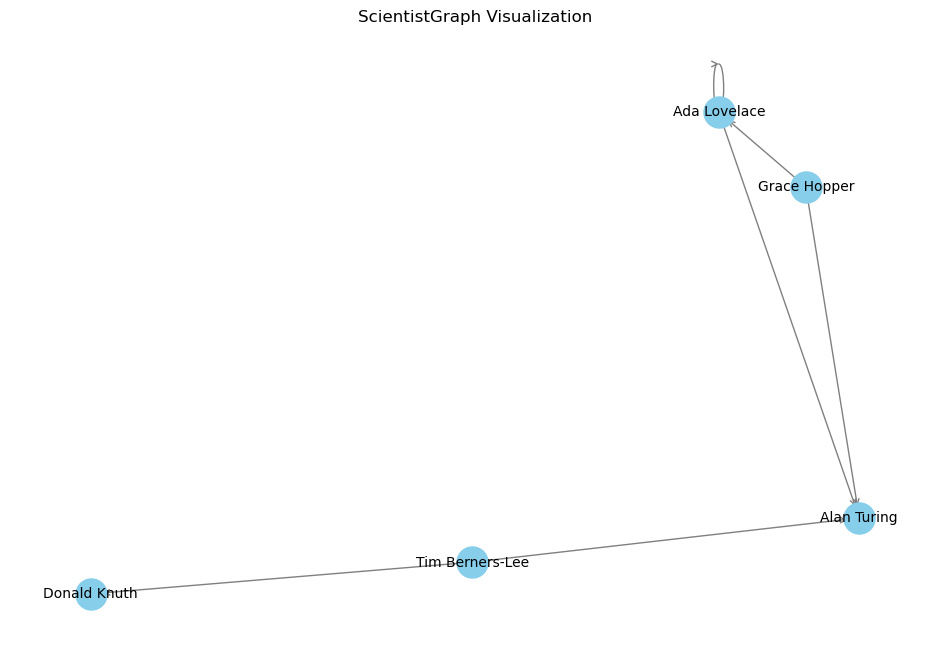

In [20]:
scientist_graph = ScientistGraph()

scientist_graph.add_scientist("Alan Turing")
scientist_graph.add_scientist("Ada Lovelace")
scientist_graph.add_scientist("Grace Hopper")
scientist_graph.add_scientist("Donald Knuth")
scientist_graph.add_scientist("Tim Berners-Lee")

scientist_graph.plot()


In [21]:
pagerank = scientist_graph.rank_scientists(method='pagerank')
print("PageRank Ranking:")
for name, score in pagerank:
    print(f"{name}: {score:.4f}")


INFO:__main__:Ranking scientists using method: pagerank
INFO:__main__:Ranking completed using method: pagerank


PageRank Ranking:
Alan Turing: 0.3297
Ada Lovelace: 0.2814
Donald Knuth: 0.1618
Grace Hopper: 0.1136
Tim Berners-Lee: 0.1136


In [22]:
degree_rank = scientist_graph.rank_scientists(method='degree')
print("\nDegree Centrality Ranking:")
for name, degree in degree_rank:
    print(f"{name}: {degree}")

INFO:__main__:Ranking scientists using method: degree
INFO:__main__:Ranking completed using method: degree



Degree Centrality Ranking:
Ada Lovelace: 4
Alan Turing: 3
Grace Hopper: 2
Tim Berners-Lee: 2
Donald Knuth: 1


INFO:__main__:Attempting to remove scientist: Grace Hopper
INFO:__main__:Removed scientist 'Grace Hopper' from the graph.


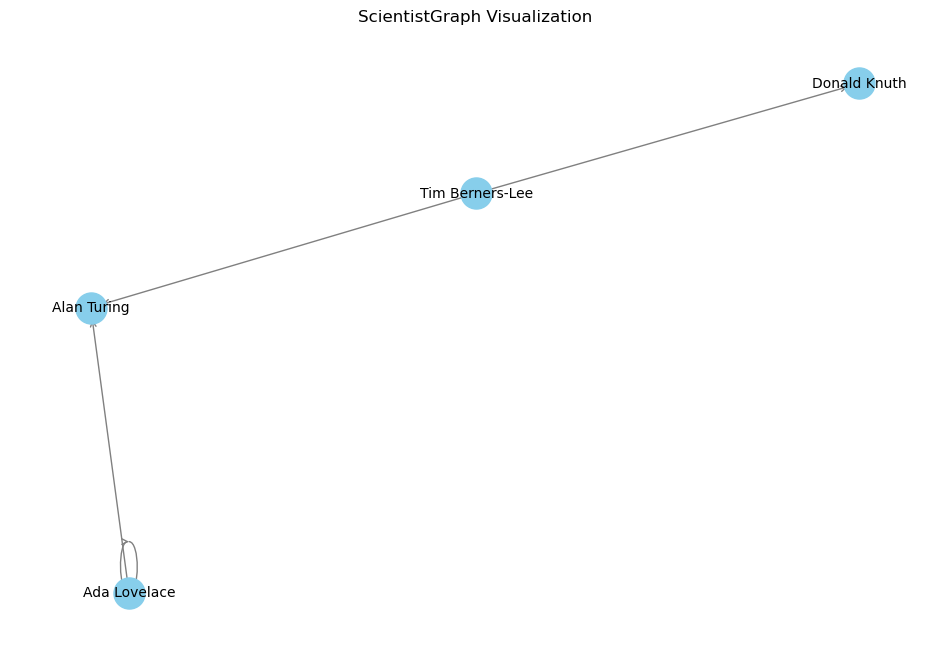

In [23]:
scientist_graph.remove_scientist("Grace Hopper")
scientist_graph.plot()